### Predicting $SPY with a LSTM Neural Network

In [19]:
import datetime
import itertools
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import mplfinance as mpf
from matplotlib.dates import MonthLocator, DateFormatter
import random
import seaborn as sns
import time

%matplotlib inline

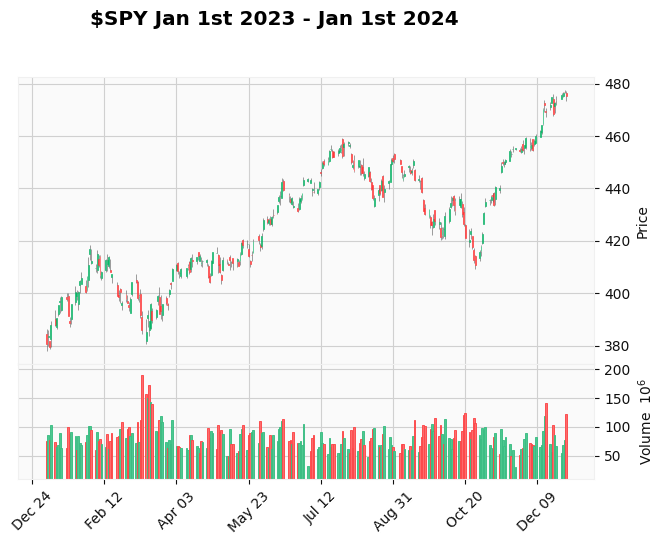

In [39]:
'''
Only read in the Date, Open, High, Low, Close, and Volume

Train on: January 1st 2023 - January 1st 2024
Test on: January 1st 2024 - March 1st 2024
'''

spy_df = pd.read_csv('SPY.csv', index_col=0, parse_dates=['Date'], usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

spy_df_train = spy_df.loc['2023-01-01':'2024-01-01']
spy_df_test = spy_df.loc['2024-01-01':'2024-03-01']

mpf.plot(spy_df_train, type='candle', volume=True, show_nontrading=True, title='$SPY Jan 1st 2023 - Jan 1st 2024', style='yahoo')

